# can we find a coordiante that we candenine between the 1000 m and 2000 m isobath?

test done with mom6-panan because I had already different isobaths for it

In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib.colors as col
import cf_xarray as cf
# need to install opencv-python for this:
import cv2
import warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/ik11/users/wf4500/Project_panan/GH/Panan_HT_ASC/figs/'

In [2]:
client = Client(threads_per_worker = 1)

In [3]:
files_dir =  '/g/data/ik11/users/wf4500/Project_panan/GH/Panan_HT_ASC/contours/'

#1000m isobaths
panan01_1000m = np.load(files_dir + 'Antarctic_slope_contour_Panan01_1000m.npz')
#2000m isobaths
panan01_2000m = np.load(files_dir + 'Antarctic_slope_contour_Panan01_Smoothedtopography_2000m.npz')
#700m isobaths
panan01_700m = np.load(files_dir + 'Antarctic_slope_contour_Panan01_Smoothedtopography_700m.npz')


In [4]:
catalog = intake.cat.access_nri

In [5]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

In [6]:
ilat_range_01 = slice(0,panan01_1000m['contour_masked_above'].shape[0])
depth  = importer("panant-01-zstar-ACCESSyr2",catalog,"deptho").compute()
yh = depth.yh.isel(yh=ilat_range_01)
xh = depth.xh
depth_cut = depth.isel(yh=ilat_range_01)

In [7]:
#transformin into xarrays - 1000m isobath
xr_panan01_1000m = depth_cut.copy()
xr_panan01_1000m.values = np.where(panan01_1000m['contour_masked_above']>0,panan01_1000m['contour_masked_above'],np.nan)
xr_panan01_1000m.name='1000misobath'
#transformin into xarrays - 7000m isobath
xr_panan01_700m = depth_cut.copy()
xr_panan01_700m.values = np.where(panan01_700m['contour_masked_above']>0,panan01_700m['contour_masked_above'],np.nan)
xr_panan01_700m.name='700misobath'
#transformin into xarrays - 2000m isobath
xr_panan01_2000m = depth_cut.copy()
xr_panan01_2000m.values = np.where(panan01_2000m['contour_masked_above']>0,panan01_2000m['contour_masked_above'],np.nan)
xr_panan01_2000m.name='2000misobath'

In [8]:
#calculating xh and yh along isobath to later calcualte distances longs
xr_panan01_700m_longs = (1 + xr_panan01_700m*0) * xr_panan01_700m.xh
xr_panan01_1000m_longs = (1 + xr_panan01_1000m*0) * xr_panan01_1000m.xh
xr_panan01_2000m_longs = (1 + xr_panan01_2000m*0) * xr_panan01_2000m.xh
#calculating xh and yh along isobath to later calcualte distances lats
xr_panan01_700m_lats = (1 + xr_panan01_700m*0) * xr_panan01_700m.yh
xr_panan01_1000m_lats = (1 + xr_panan01_1000m*0) * xr_panan01_1000m.yh
xr_panan01_2000m_lats = (1 + xr_panan01_2000m*0) * xr_panan01_2000m.yh


Calculating distances along isobath. this will be done for each isobath separately because they require long cellds

In [9]:
#first for the 700 m isobath
test_x = xr_panan01_700m.stack(contour={'xh','yh'}).dropna(dim='contour').xh
test_y = xr_panan01_700m.stack(contour={'xh','yh'}).dropna(dim='contour').yh
test_order = xr_panan01_700m.stack(contour={'xh','yh'}).dropna(dim='contour')
test_x = test_x.sortby(test_order)
test_y = test_y.sortby(test_order)
x_700misobath = test_x.copy()
y_700misobath = test_y.copy()
#calcualting distances along isobath
import numpy as np
from geopy.distance import geodesic

distances = [
    geodesic((test_y [i], test_x[i]), (test_y [i+1], test_x[i+1])).meters
    for i in range(len(test_x)-1)
]

distances_along_isobath_700m = np.cumsum(np.append(0,np.array(distances))/1000)

xr_distances_along_isobath_700m  = test_order.copy()
xr_distances_along_isobath_700m = xr_distances_along_isobath_700m.sortby(test_order)
xr_distances_along_isobath_700m.values = distances_along_isobath_700m 
xr_distances_along_isobath_700m_linear = xr_distances_along_isobath_700m.copy()
longitudes_700m = test_x.copy()
latitudes_700m = test_y.copy()
#unstacking to get the matrix of distances along isobath
xr_distances_along_isobath_700m = xr_distances_along_isobath_700m.unstack().sortby('yh').sortby('xh')
xr_distances_along_isobath_700m = xr_distances_along_isobath_700m.reindex(yh=xr_panan01_700m.yh) #fixing unstacked y coords

In [10]:
#second for the 1000 m isobath
test_x = xr_panan01_1000m.stack(contour={'xh','yh'}).dropna(dim='contour').xh
test_y = xr_panan01_1000m.stack(contour={'xh','yh'}).dropna(dim='contour').yh
test_order = xr_panan01_1000m.stack(contour={'xh','yh'}).dropna(dim='contour')
test_x = test_x.sortby(test_order)
test_y = test_y.sortby(test_order)
x_1000misobath = test_x.copy()
y_1000misobath = test_y.copy()

#calcualting distances along isobath
distances = [
    geodesic((test_y [i], test_x[i]), (test_y [i+1], test_x[i+1])).meters
    for i in range(len(test_x)-1)
]

distances_along_isobath_1000m = np.cumsum(np.append(0,np.array(distances))/1000)

xr_distances_along_isobath_1000m  = test_order.copy()
xr_distances_along_isobath_1000m = xr_distances_along_isobath_1000m.sortby(test_order)
xr_distances_along_isobath_1000m.values = distances_along_isobath_1000m 
#unstacking to get the matrix of distances along isobath
xr_distances_along_isobath_1000m = xr_distances_along_isobath_1000m.unstack().sortby('yh').sortby('xh')
xr_distances_along_isobath_1000m = xr_distances_along_isobath_1000m.reindex(yh=xr_panan01_1000m.yh) #fixing unstacked y coords

In [11]:
#finally for the for the 2000 m isobath
test_x = xr_panan01_2000m.stack(contour={'xh','yh'}).dropna(dim='contour').xh
test_y = xr_panan01_2000m.stack(contour={'xh','yh'}).dropna(dim='contour').yh
test_order = xr_panan01_2000m.stack(contour={'xh','yh'}).dropna(dim='contour')
test_x = test_x.sortby(test_order)
test_y = test_y.sortby(test_order)
x_2000misobath = test_x.copy()
y_2000misobath = test_y.copy()
#calcualting distances along isobath
distances = [
    geodesic((test_y [i], test_x[i]), (test_y [i+1], test_x[i+1])).meters
    for i in range(len(test_x)-1)
]

distances_along_isobath_2000m = np.cumsum(np.append(0,np.array(distances))/1000)

xr_distances_along_isobath_2000m  = test_order.copy()
xr_distances_along_isobath_2000m = xr_distances_along_isobath_2000m.sortby(test_order)
xr_distances_along_isobath_2000m.values = distances_along_isobath_2000m 
#unstacking to get the matrix of distances along isobath
xr_distances_along_isobath_2000m = xr_distances_along_isobath_2000m.unstack().sortby('yh').sortby('xh')
xr_distances_along_isobath_2000m = xr_distances_along_isobath_2000m.reindex(yh=xr_panan01_2000m.yh)

In [12]:
# #before - using indexes
# panan01_700m_normalized = panan01_700m['contour_masked_above']/np.max(panan01_700m['contour_masked_above'])
# panan01_1000m_normalized = panan01_1000m['contour_masked_above']/np.max(panan01_1000m['contour_masked_above'])
# panan01_2000m_normalized = panan01_2000m['contour_masked_above']/np.max(panan01_2000m['contour_masked_above'])

#now, using distances
panan01_700m_normalized = np.array(xr_distances_along_isobath_700m/np.max(xr_distances_along_isobath_700m ))
panan01_1000m_normalized = np.array(xr_distances_along_isobath_1000m/np.max(xr_distances_along_isobath_1000m ))
panan01_2000m_normalized = np.array(xr_distances_along_isobath_2000m/np.max(xr_distances_along_isobath_2000m ))

In [13]:
import numpy as np
import scipy.ndimage as nd

def fill_nan_nearest(a):
    # mask NaNs
    mask = np.isnan(a)
    # indices of nearest non-NaN for each element
    idx = nd.distance_transform_edt(mask, return_indices=True)
    return a[tuple(idx)]

In [14]:
#creating 2-contour file
panan01_2isobaths = np.nan_to_num(panan01_700m_normalized, nan=0.0)+np.nan_to_num(panan01_2000m_normalized, nan=0.0)
panan01_2isobaths = np.where(panan01_2isobaths<=1,panan01_2isobaths,panan01_700m_normalized) #isobaths located in the same point then just use the shallower isobath as coordinate
panan01_2isobaths = np.where(panan01_2isobaths>0,panan01_2isobaths,np.nan)

In [15]:
#transformin into xarray to fill nans
xr_panan01_2isobaths = depth_cut.copy()
xr_panan01_2isobaths.values = panan01_2isobaths
xr_panan01_2isobaths.name='TwoIsobaths'

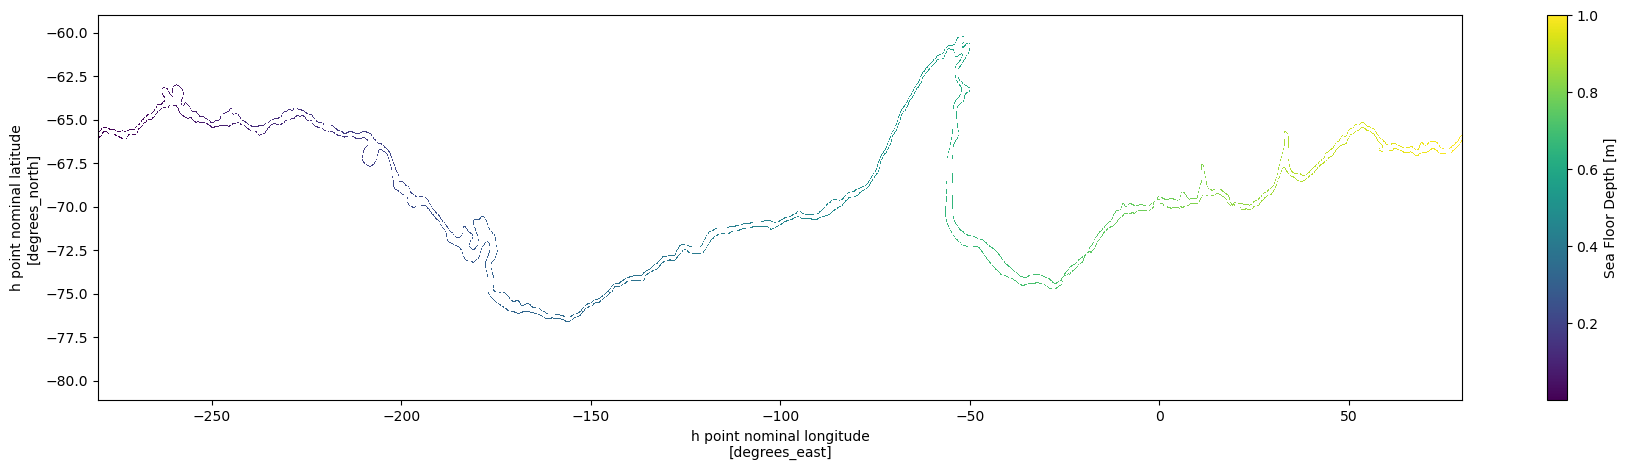

In [16]:
plt.figure(figsize=(22,5))
xr_panan01_2isobaths.plot()

In [17]:
#2d interpolator
from scipy.interpolate import griddata
def interpolate_na_2d(da, method="linear"):
    """
    Fill NaNs in a 2D xarray.DataArray using 2D interpolation 
    (linear, nearest, or cubic).
    """
    if da.ndim != 2:
        raise ValueError("Only works for 2D DataArray")

    x, y = np.meshgrid(da[da.dims[1]], da[da.dims[0]])
    values = da.values

    # valid (non-NaN) points
    mask = ~np.isnan(values)
    points = np.column_stack((x[mask], y[mask]))
    vals   = values[mask]

    # all grid points
    all_points = np.column_stack((x.ravel(), y.ravel()))

    # interpolate
    filled = griddata(points, vals, all_points, method=method)
    filled = filled.reshape(values.shape)

    return xr.DataArray(
        filled,
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs
    )

In [18]:
def interpolate_along_guide(da, guide, method="linear"):
    """
    Interpolate missing values in 'da' using 'guide' as the interpolation axis.
    Works like field-aligned interpolation along the gradient of 'guide'.
    
    Parameters
    ----------
    da : xr.DataArray (2D)
        Data to interpolate, with NaNs
    guide : xr.DataArray (2D)
        Guiding variable (e.g., bathymetry), same shape as da
    method : str
        np.interp method: "linear", "nearest"
    """
    if da.shape != guide.shape:
        raise ValueError("da and guide must have the same shape")
    
    filled = da.copy()
    values = da.values
    guide_vals = guide.values
    
    # Loop over each column (or row) and interpolate along guide axis
    for i in range(values.shape[0]):
        mask = ~np.isnan(values[i, :])
        if mask.sum() >= 2:  # need at least 2 points to interpolate
            filled[i, :] = np.interp(
                guide_vals[i, :],
                guide_vals[i, mask],
                values[i, mask]
            )
    
    return filled

In [19]:
#interpolates values across isobath
def interpolate_along_gradient(da, guide, n_steps=50, step=1.0):
    """
    Interpolate missing values in da along gradient lines of guide.
    """
    filled = da.copy().values
    gx, gy = np.gradient(guide.values)
    norm = np.sqrt(gx**2 + gy**2)
    ux, uy = gx / (norm + 1e-12), gy / (norm + 1e-12)  # unit normals

    ny, nx = da.shape
    for j in range(ny):
        for i in range(nx):
            if np.isnan(filled[j, i]) and not np.isnan(guide.values[j, i]):
                vals = []
                for sign in [-1, 1]:
                    x, y = float(i), float(j)
                    for _ in range(n_steps):
                        xi = int(round(x))
                        yi = int(round(y))
                        if not (0 <= xi < nx and 0 <= yi < ny):
                            break
                        dx, dy = sign * ux[yi, xi], sign * uy[yi, xi]
                        if np.isnan(dx) or np.isnan(dy):
                            break
                        x_new, y_new = x + step * dx, y + step * dy
                        if not (0 <= x_new < nx and 0 <= y_new < ny):
                            break
                        x, y = x_new, y_new
                        xi = np.clip(int(round(x)), 0, nx - 1)
                        yi = np.clip(int(round(y)), 0, ny - 1)
                        if not np.isnan(filled[yi, xi]):
                            vals.append(filled[yi, xi])
                            break
                if vals:
                    filled[j, i] = np.mean(vals)

    return xr.DataArray(filled, coords=da.coords, dims=da.dims)

In [20]:
from scipy.ndimage import distance_transform_edt
def propagate_along_gradient(source_vals, guide, start_mask, n_steps=10, step=1.0):
    """
    Propagate values from a source contour along the across-slope direction
    defined by the gradient of 'guide'. All points between contours will be filled.

    Parameters
    ----------
    source_vals : xr.DataArray (2D)
        Values defined at the source contour (NaN elsewhere).
    guide : xr.DataArray (2D)
        Guiding variable (e.g., bathymetry).
    start_mask : xr.DataArray (bool, 2D)
        Mask that marks the source contour (True at contour points).
    n_steps : int
        Max number of steps to propagate along gradient.
    step : float
        Step size in grid units.
    """
    ny, nx = source_vals.shape
    gx, gy = np.gradient(guide.values)
    norm = np.sqrt(gx**2 + gy**2) + 1e-12
    ux, uy = gx/norm, gy/norm  # unit vectors across slope

    filled = np.full_like(source_vals.values, np.nan, dtype=float)
    counts = np.zeros_like(filled, dtype=int)

    # initialize at contour
    contour_points = np.argwhere(start_mask.values)
    for (j, i) in contour_points:
        start_val = source_vals.values[j, i]
        if np.isnan(start_val):
            continue

        for sign in [1, -1]:  # propagate both directions
            x, y = float(i), float(j)
            for _ in range(n_steps):
                xi = int(round(x))
                yi = int(round(y))
                if not (0 <= xi < nx and 0 <= yi < ny):
                    break
                dx, dy = sign * ux[yi, xi], sign * uy[yi, xi]
                if np.isnan(dx) or np.isnan(dy):
                    break
                # write value (accumulate if multiple sources reach same cell)
                if np.isnan(filled[yi, xi]):
                    filled[yi, xi] = start_val
                    counts[yi, xi] = 1
                else:
                    filled[yi, xi] += start_val
                    counts[yi, xi] += 1
                # move forward
                x_new, y_new = x + step*dx, y + step*dy
                if not (0 <= x_new < nx and 0 <= y_new < ny):
                    break
                x, y = x_new, y_new

    # normalize where multiple streamlines overlapped
    mask = counts > 0
    filled[mask] = filled[mask] / counts[mask]

    # fill any gaps (NaNs) with nearest neighbour from the filled mask
    if np.isnan(filled).any():
        nan_mask = np.isnan(filled)
        dist, (inds_y, inds_x) = distance_transform_edt(
            nan_mask, return_indices=True
        )
        filled[nan_mask] = filled[inds_y[nan_mask], inds_x[nan_mask]]

    return xr.DataArray(filled, coords=source_vals.coords, dims=source_vals.dims)

In [21]:
import xarray as xr
import numpy as np
from scipy.ndimage import distance_transform_edt

#function below will be used to create the along slope coordinate
def propagate_radially(data):
    """
    Propagate values radially from valid points in a 2D xarray.DataArray.
    NaNs in `data` are filled using nearest valid neighbors.
    
    Parameters
    ----------
    data : xarray.DataArray
        2D array with valid values at some points and NaNs elsewhere.
        
    Returns
    -------
    propagated : xarray.DataArray
        Fully populated array with values propagated radially from seeds.
    """
    # Create mask of valid values
    valid_mask = ~np.isnan(data.values)
    
    if valid_mask.sum() == 0:
        raise ValueError("No valid data points to propagate from.")
    
    # Compute distance transform and indices of nearest valid point
    dist, indices = distance_transform_edt(~valid_mask, return_indices=True)
    
    # Propagate values: assign each point the value of its nearest valid neighbor
    propagated_values = data.values[indices[0], indices[1]]
    
    # Return as xarray
    return xr.DataArray(propagated_values, coords=data.coords, dims=data.dims)



#function below used to calculate the across-slope distance coordinate
def radial_distance_from_seeds(data, dx, dy):
    """
    Compute radial distances from valid points in a 2D xarray.DataArray.

    Parameters
    ----------
    data : xarray.DataArray
        2D array with valid values at some points (NaNs elsewhere) acting as seed points.
    dx : xarray.DataArray or 2D array
        Grid spacing in x-direction (same shape as `data` or broadcastable).
    dy : xarray.DataArray or 2D array
        Grid spacing in y-direction (same shape as `data` or broadcastable).

    Returns
    -------
    distances : xarray.DataArray
        Radial distance from the nearest valid seed point, in the same units as dx/dy.
    """
    # Mask of valid points
    valid_mask = ~np.isnan(data.values)
    
    if valid_mask.sum() == 0:
        raise ValueError("No valid data points to compute distances from.")
    
    # Compute distance transform with pixel counts
    pixel_distances, indices = distance_transform_edt(~valid_mask, return_indices=True)
    
    # Compute distances in real units
    # Calculate differences along x and y from nearest seed
    y_idx, x_idx = np.indices(data.shape)
    nearest_y = indices[0]
    nearest_x = indices[1]
    
    dy_arr = np.asarray(dy)
    dx_arr = np.asarray(dx)
    
    # Compute cumulative distance along y and x
    dist_y = (y_idx - nearest_y) * dy_arr
    dist_x = (x_idx - nearest_x) * dx_arr
    
    # Euclidean distance
    distances = np.sqrt(dist_x**2 + dist_y**2)
    
    # Return as xarray
    return xr.DataArray(distances, coords=data.coords, dims=data.dims)

In [22]:
#creating masks for shalow and deep sea
mask_below700m = np.where(panan01_700m['contour_masked_above']<0,1,np.nan)
mask_above2000m = np.where(panan01_2000m['contour_masked_above']<0,np.nan,1)
#transforming then into xarrays
#below mask
xr_mask_below700m = depth_cut.copy()
xr_mask_below700m.values = mask_below700m
xr_mask_below700m.name='maskbelow700'

#above mask
xr_mask_above2000m = depth_cut.copy()
xr_mask_above2000m.values = mask_above2000m
xr_mask_above2000m.name='maskabove2000'

In [23]:
#masking depth_cut for the interpoaltion
depth_cut_masked  = depth_cut*xr_mask_above2000m*xr_mask_below700m 
#depth_cut_masked  =xr.concat([depth_cut_masked[:,-1],depth_cut_masked,depth_cut_masked[:,0]], dim='xh')
#1 degree smoothing to get rid of wiggliness
depth_cut_smoothed = depth_cut.cf.rolling({'longitude':100,'latitude':100},min_periods=1).mean()

In [24]:
#propagating across slope
xr_distances_along_isobath_700m_propagated = propagate_along_gradient(xr_distances_along_isobath_700m, depth_cut_smoothed, xr.where(xr_distances_along_isobath_700m.notnull(), True, False), n_steps=200, step=1.0) 
xr_distances_along_isobath_700m_propagated = xr_distances_along_isobath_700m_propagated*xr_mask_above2000m*xr_mask_below700m 

In [25]:
#propagating across slope, when defined by 2 single isobaths
dxt  = importer("panant-01-zstar-ACCESSyr2",catalog,"dxt").isel(yh=ilat_range_01).compute()
dyt  = importer("panant-01-zstar-ACCESSyr2",catalog,"dyt").isel(yh=ilat_range_01).compute()
xr_distances_along_isobath_700m_propagated_radially = propagate_radially(xr_distances_along_isobath_700m)
xr_distances_along_isobath_700m_propagated_radially = xr_distances_along_isobath_700m_propagated_radially*xr_mask_above2000m*xr_mask_below700m 
xr_crossdistances_along_isobath_700m_propagated_radially = radial_distance_from_seeds(xr_distances_along_isobath_700m, dxt*0.001, dyt*0.001) #dxt and dyt calcualted here in km now
xr_crossdistances_along_isobath_700m_propagated_radially = xr_crossdistances_along_isobath_700m_propagated_radially*xr_mask_above2000m*xr_mask_below700m 

In [26]:
# xr_panan01_2isobaths_filled = interpolate_na_2d(xr_panan01_2isobaths, method="linear")

In [27]:
# xr_panan01_2isobaths_filled_guided  = interpolate_along_gradient(xr_panan01_2isobaths, depth_cut_masked, n_steps=50, step=1.0)
# xr_panan01_2isobaths_filled_guided = xr_panan01_2isobaths_filled_guided *xr_mask_above2000m*xr_mask_below700m

In [28]:
# xr_panan01_2isobaths_masked = xr_panan01_2isobaths_filled *xr_mask_above2000m * xr_mask_below700m 

In [29]:
#xr_distances_along_isobath_700m_propagated_radially seem to work good!

Text(0, 0.5, 'Latitude')

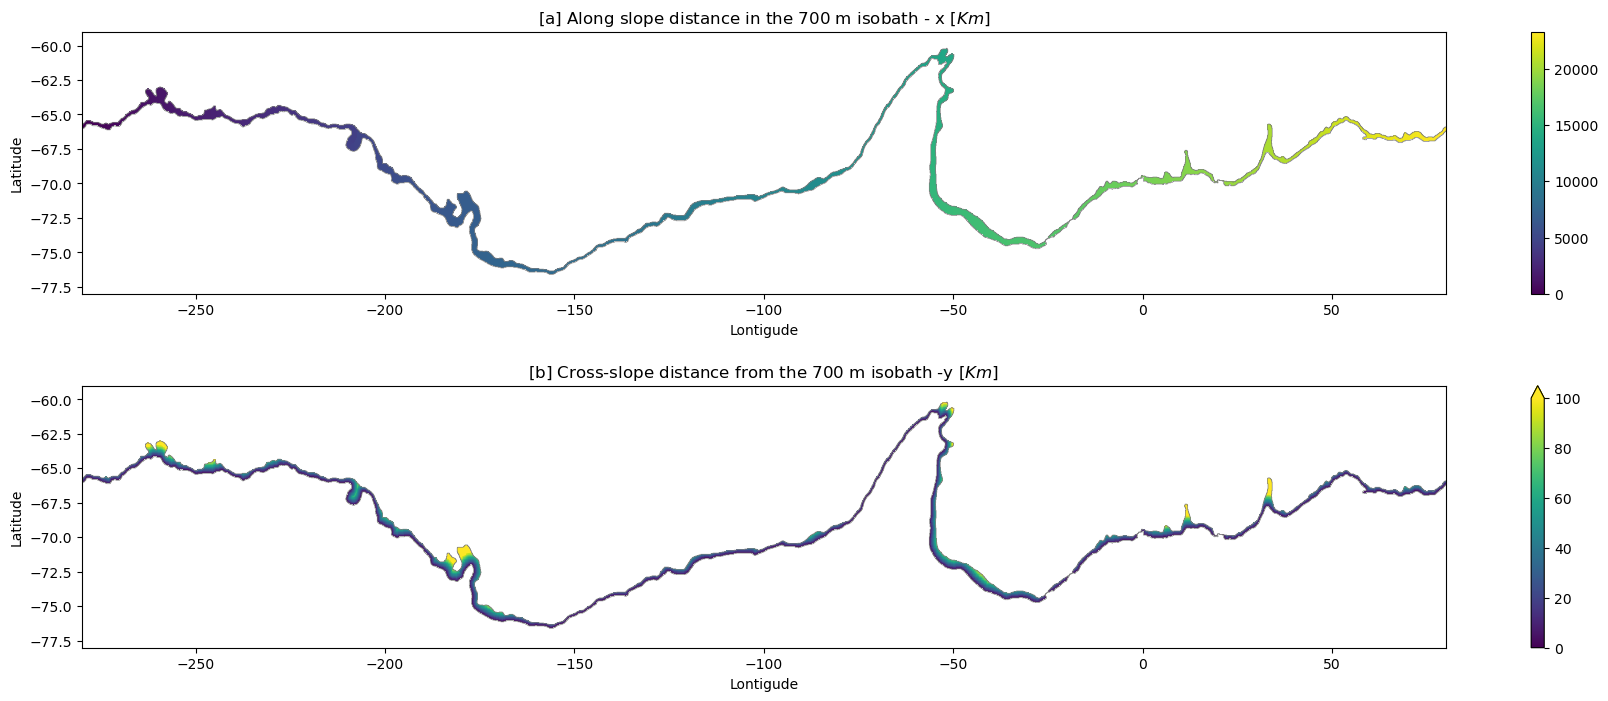

In [56]:
plt.figure(figsize=(22,8))
plt.subplots_adjust( hspace=.35)
plt.subplot(2,1,1)
plt.plot(x_700misobath,y_700misobath,color='grey',linewidth=0.5) #700 m isobath
plt.plot(x_2000misobath,y_2000misobath,color='grey',linewidth=0.5) #2000 m isobath
xr_distances_along_isobath_700m_propagated_radially.plot()
plt.title(r'[a] Along slope distance in the 700 m isobath - x [$Km$]')
plt.ylim(-78,-59)
plt.xlabel('Lontigude'); plt.ylabel('Latitude')

plt.subplot(2,1,2)
plt.plot(x_700misobath,y_700misobath,color='grey',linewidth=0.5) #700 m isobath
plt.plot(x_2000misobath,y_2000misobath,color='grey',linewidth=0.5) #2000 m isobath
xr_crossdistances_along_isobath_700m_propagated_radially.plot(vmin=0,vmax=100)
plt.title(r'[b] Cross-slope distance from the 700 m isobath -y [$Km$]')
plt.ylim(-78,-59)
plt.xlabel('Lontigude'); plt.ylabel('Latitude')

(-68.0, -62.5)

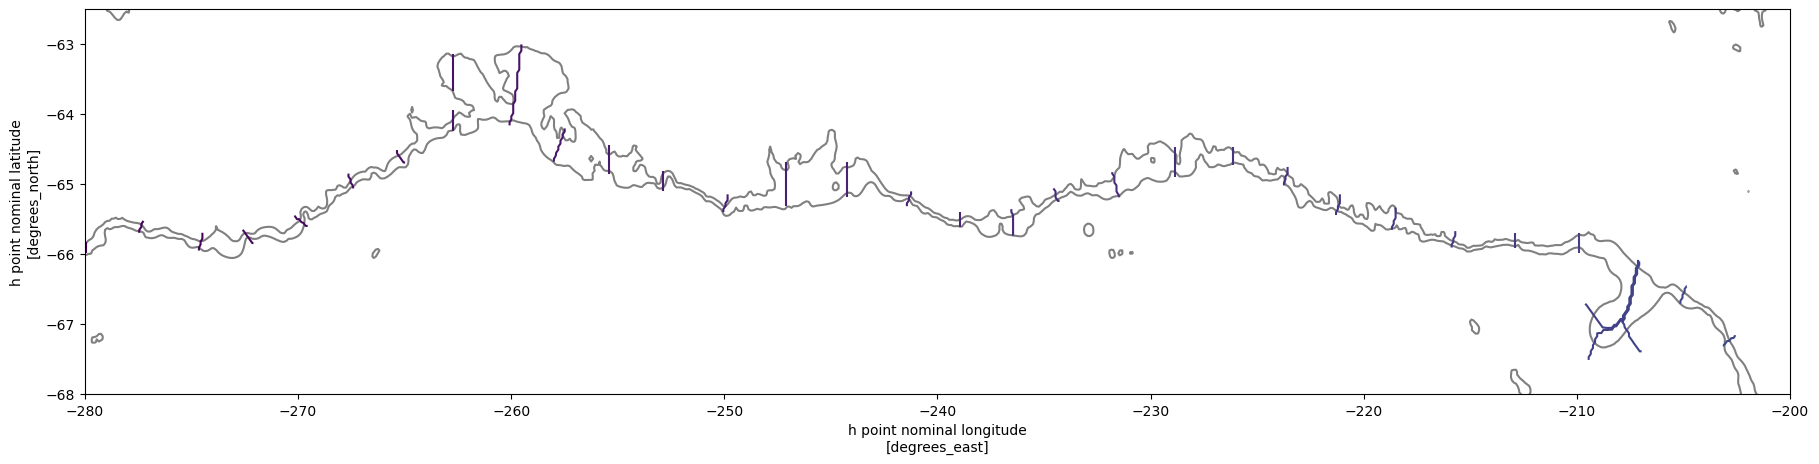

In [31]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),150))
plt.xlim(-280,-200)
plt.ylim(-68,-62.5)

(-77.0, -68.0)

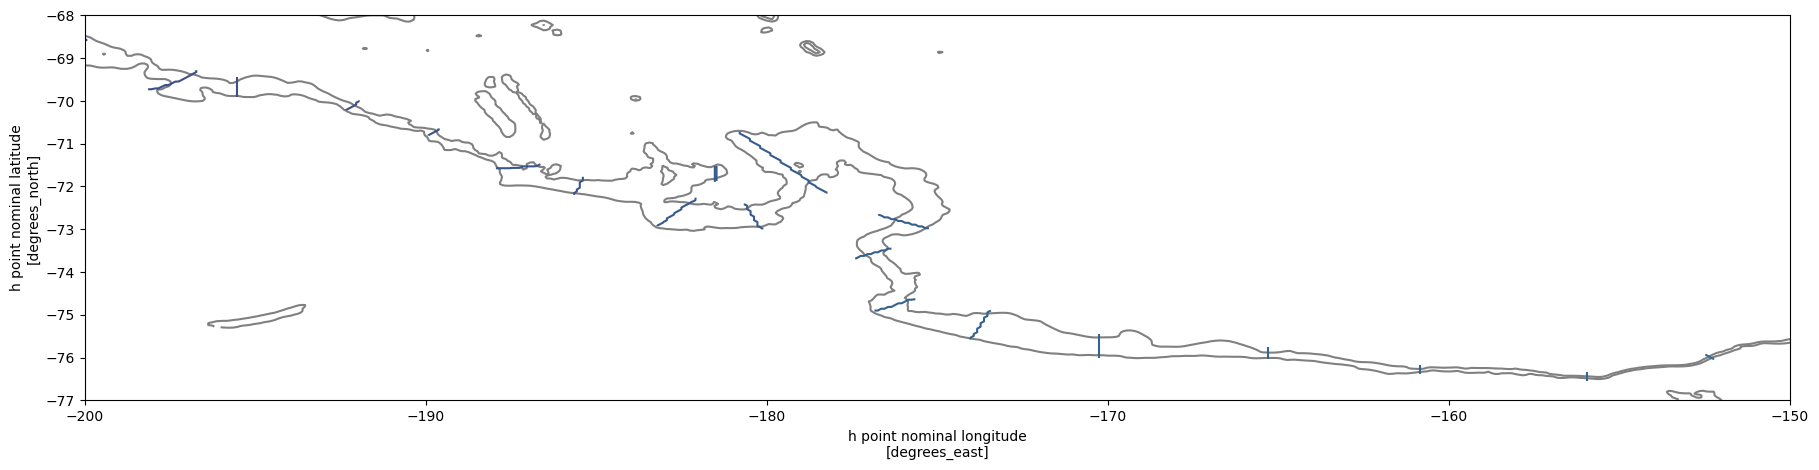

In [32]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),150))
plt.xlim(-200,-150)
plt.ylim(-77,-68)

(-77.0, -67.0)

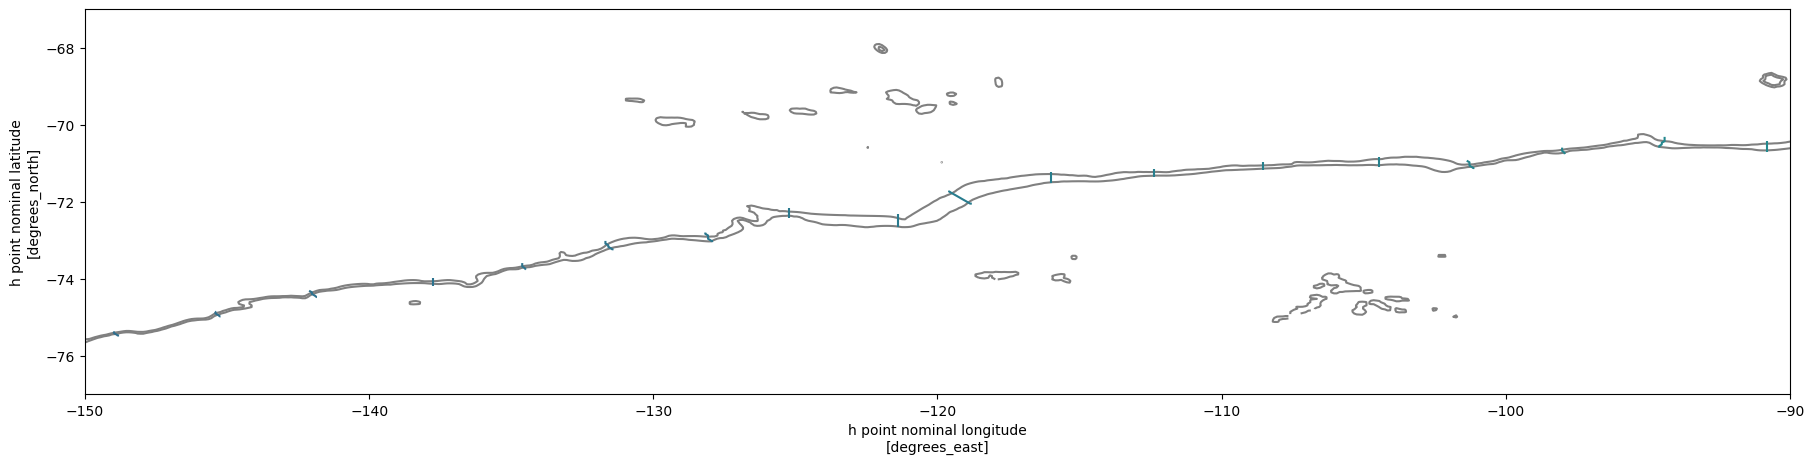

In [33]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),150))
plt.xlim(-150,-90)
plt.ylim(-77,-67)

(-72.0, -58.0)

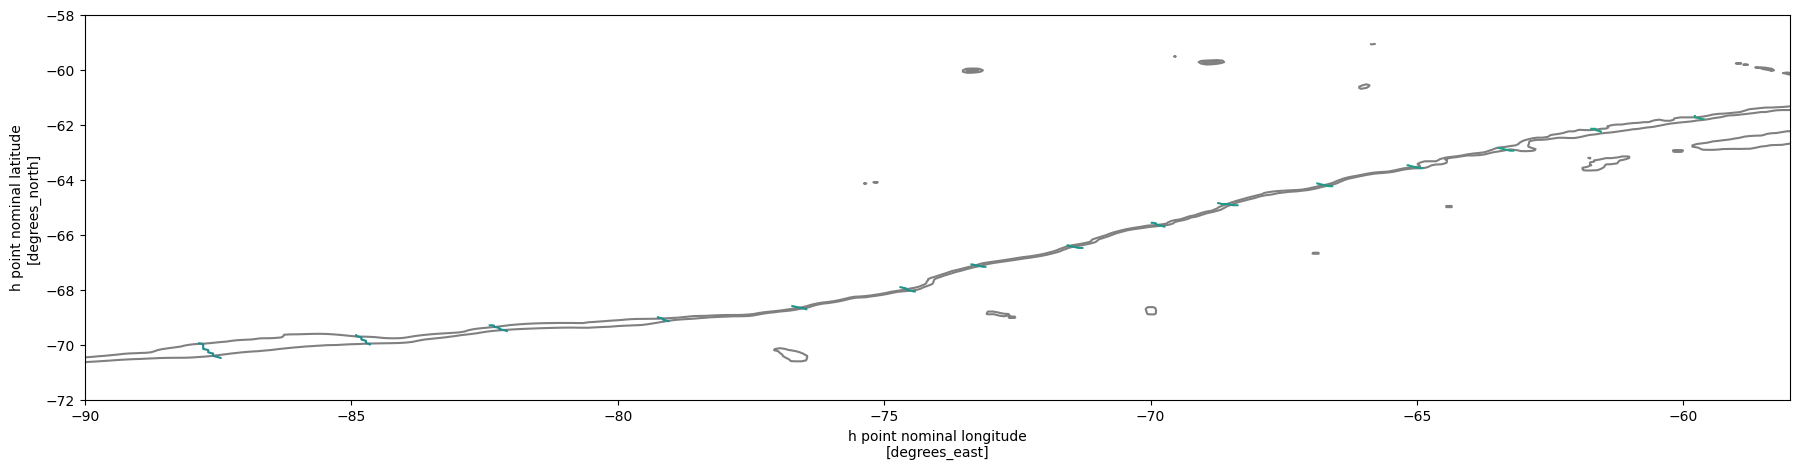

In [34]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),150))
plt.xlim(-90,-58)
plt.ylim(-72,-58)

<a list of 196 text.Text objects>

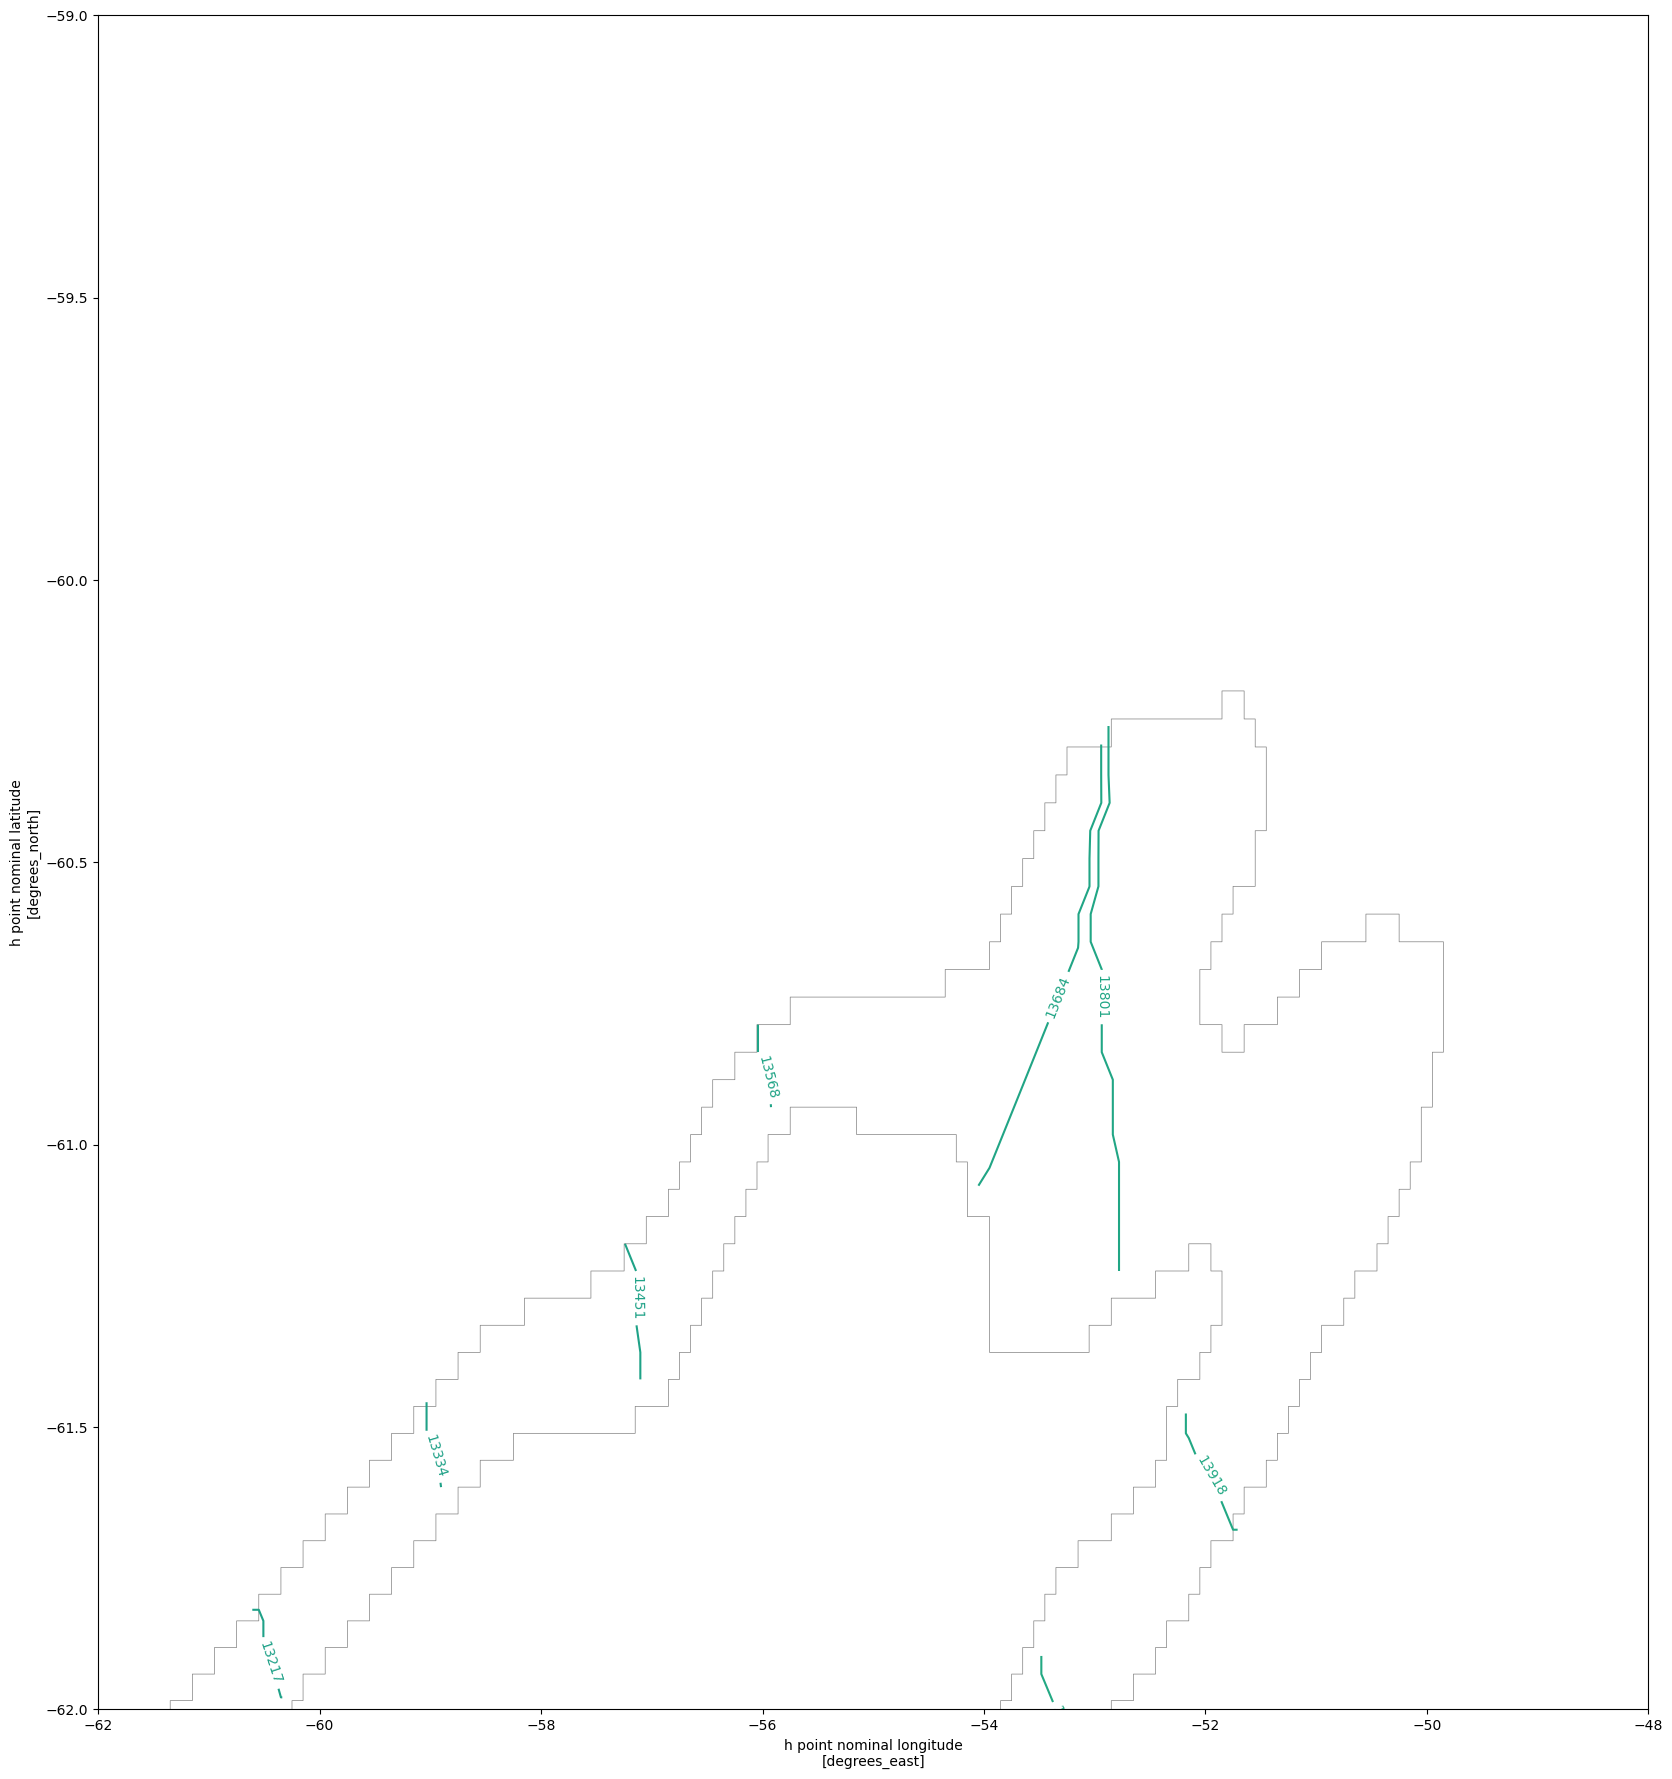

In [38]:
plt.figure(figsize=(20,22))
# depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
plt.plot(x_700misobath,y_700misobath,color='grey',linewidth=0.5) #2000 m isobath
plt.plot(x_2000misobath,y_2000misobath,color='grey',linewidth=0.5) #2000 m isobath
c = xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),200))
plt.xlim(-62,-48)
plt.ylim(-62,-59)
plt.clabel(c)

(-76.0, -68.0)

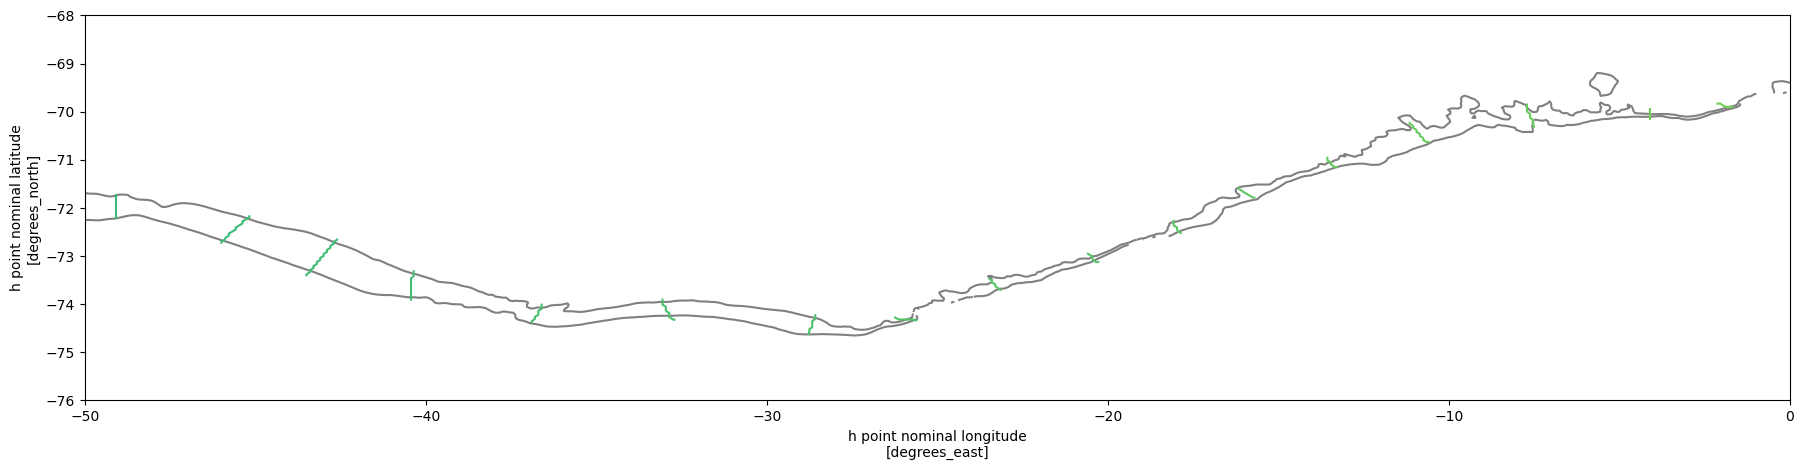

In [39]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),150))
plt.xlim(-50,0)
plt.ylim(-76,-68)

(-71.0, -64.0)

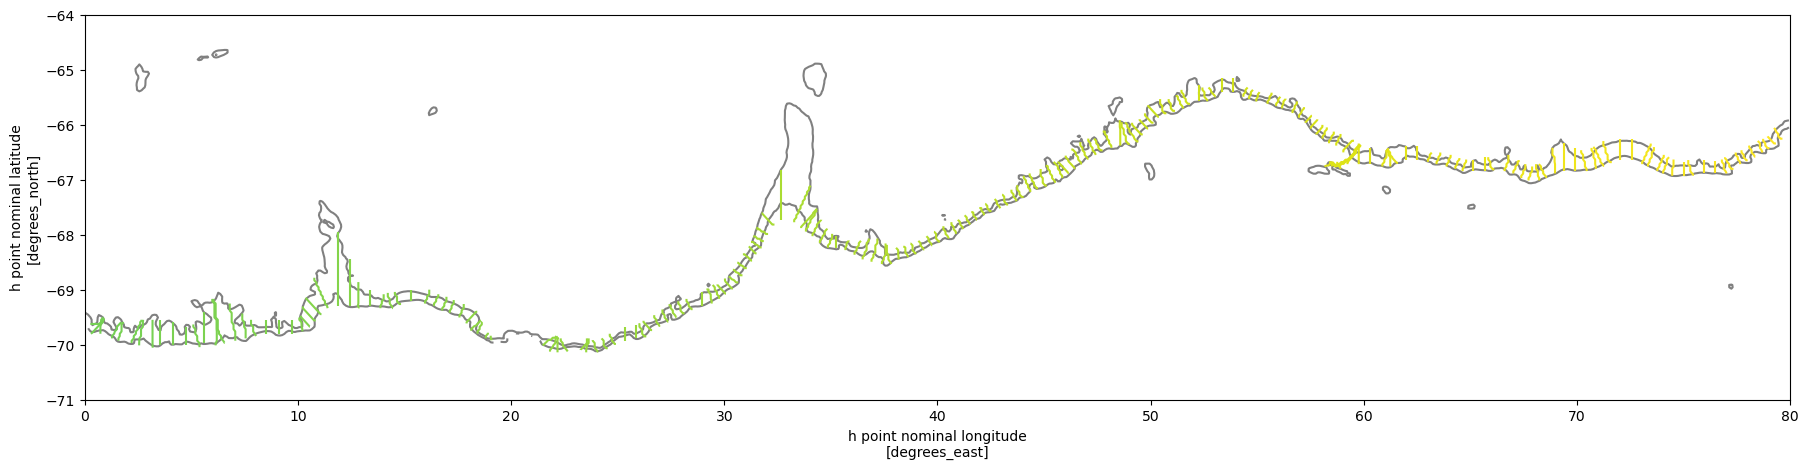

In [40]:
plt.figure(figsize=(22,5))
depth_cut.plot.contour(levels=[1000,2000],colors='grey',linewidth=0.5)
xr_distances_along_isobath_700m_propagated_radially.plot.contour(levels=np.linspace(0,xr_distances_along_isobath_700m_propagated_radially.max(),1000))
plt.xlim(0,80)
plt.ylim(-71,-64)

## Sanity test with variables

Now that we have a theorical coordinate system, lets test how variables look like when we convert to that system

In [41]:
#lets try first with calcualted speeds at surface
start_date='2000-01'
end_date = '2000-12'

In [42]:
%%time
#importing surface us
Us_01  = importer("panant-01-zstar-ACCESSyr2",catalog,"uo",frequency='1mon',start_time=start_date,end_time=end_date).isel(z_l=0).mean('time').compute()
Vs_01  = importer("panant-01-zstar-ACCESSyr2",catalog,"vo",frequency='1mon',start_time=start_date,end_time=end_date).isel(z_l=0).mean('time').compute()

#interpolating all to h points
Us_01_h = Us_01.interp(xq = Vs_01.xh)
Vs_01_h = Vs_01.interp(yq = Us_01.yh)

CPU times: user 10.6 s, sys: 3.42 s, total: 14 s
Wall time: 11.2 s


In [43]:
#calculating speed
Speed_01 = ((Us_01_h**2) + (Vs_01_h **2) )**0.5
#extracting values withing the pre-defined area ############################################################
#1st creating mask
area_mask =1+ xr_distances_along_isobath_700m_propagated_radially*0
#2nd extracting speed
Speed_01_masked = Speed_01*area_mask
Speed_01_full= Speed_01*area_mask.fillna(1)

Text(0, 0.5, 'Latitude')

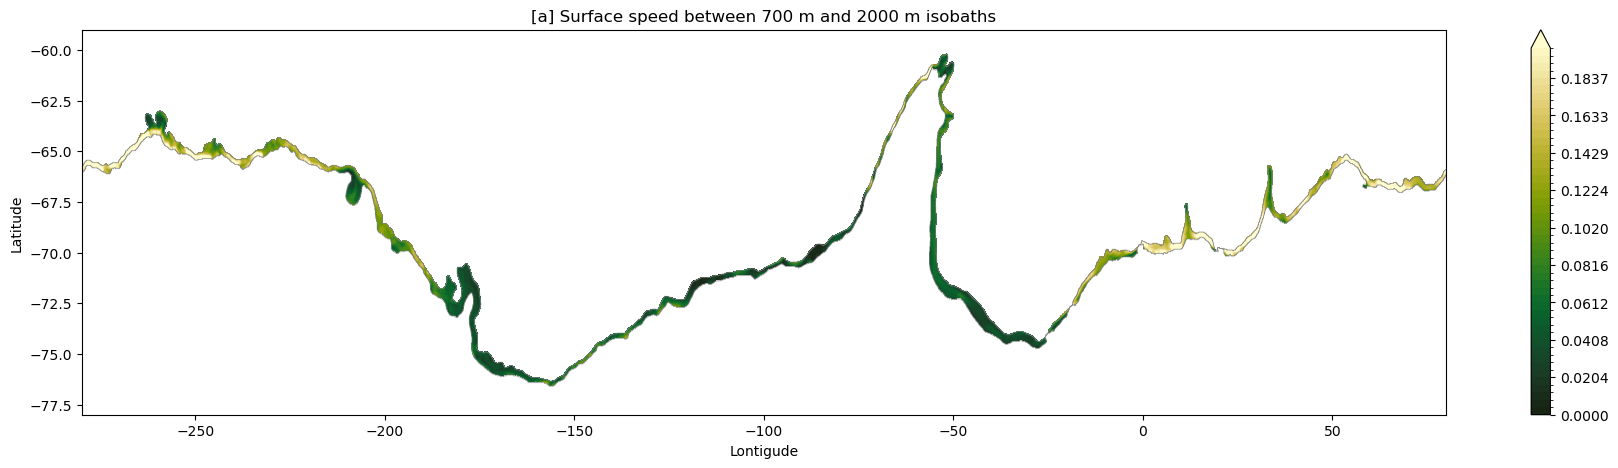

In [44]:
#Speed_01
plt.figure(figsize=(22,5))
plt.plot(x_700misobath,y_700misobath,color='grey',linewidth=0.5) #2000 m isobath
plt.plot(x_2000misobath,y_2000misobath,color='grey',linewidth=0.5) #2000 m isobath
Speed_01_masked.plot.contourf(cmap=cm.cm.speed_r,levels=50,vmin=0,vmax=0.2)
plt.title(r'[a] Surface speed between 700 m and 2000 m isobaths')
plt.ylim(-78,-59)
plt.xlabel('Lontigude'); plt.ylabel('Latitude')

(-68.0, -62.5)

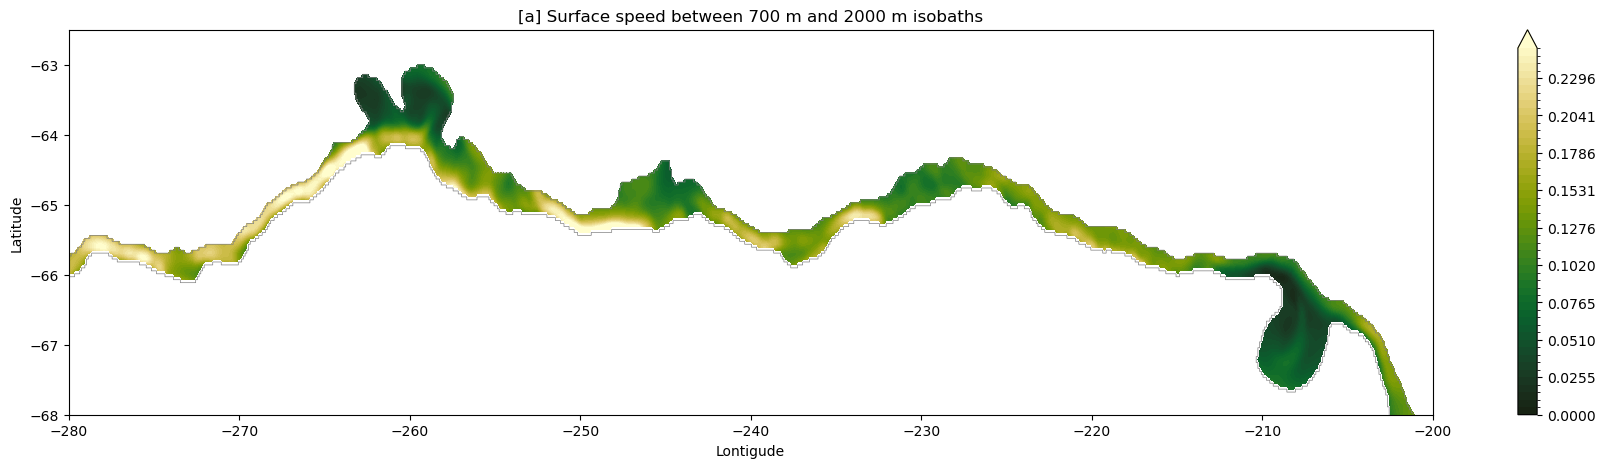

In [45]:
#Speed_01
plt.figure(figsize=(22,5))
plt.plot(x_700misobath,y_700misobath,color='grey',linewidth=0.5) #2000 m isobath
plt.plot(x_2000misobath,y_2000misobath,color='grey',linewidth=0.5) #2000 m isobath
Speed_01_masked.plot.contourf(cmap=cm.cm.speed_r,levels=50,vmin=0,vmax=0.25)
plt.title(r'[a] Surface speed between 700 m and 2000 m isobaths')
plt.ylim(-78,-59)
plt.xlabel('Lontigude'); plt.ylabel('Latitude')
plt.xlim(-280,-200)
plt.ylim(-68,-62.5)

Now let's convert the coordintes to the system I devised

In [46]:
def regrid_to_curvilinear(Speed, x_new, y_new, nx_bins=100, ny_bins=100):
    """
    Regrid a 2D field onto a new curvilinear coordinate system (x_new, y_new)
    by binning and averaging values within each bin.

    Parameters
    ----------
    Speed : xarray.DataArray
        Original 2D field to regrid (dimensions: xh, yh).
    x_new : xarray.DataArray
        2D array of new x coordinates (same shape as Speed).
    y_new : xarray.DataArray
        2D array of new y coordinates (same shape as Speed).
    nx_bins : int
        Number of bins along the x direction.
    ny_bins : int
        Number of bins along the y direction.

    Returns
    -------
    regridded : xarray.DataArray
        Regridded field with dimensions (x_bin, y_bin), averaged within bins.
    x_bins : np.ndarray
        Bin centers for x.
    y_bins : np.ndarray
        Bin centers for y.
    """
    # Flatten arrays
    x_flat = x_new.values.ravel()
    y_flat = y_new.values.ravel()
    Speed_flat = Speed.values.ravel()
    
    # Mask NaNs
    mask = ~np.isnan(Speed_flat)
    x_flat = x_flat[mask]
    y_flat = y_flat[mask]
    Speed_flat = Speed_flat[mask]
    
    # Define bins
    x_bins_edges = np.linspace(np.nanmin(x_flat), np.nanmax(x_flat), nx_bins + 1)
    y_bins_edges = np.linspace(np.nanmin(y_flat), np.nanmax(y_flat), ny_bins + 1)
    x_centers = 0.5 * (x_bins_edges[:-1] + x_bins_edges[1:])
    y_centers = 0.5 * (y_bins_edges[:-1] + y_bins_edges[1:])
    
    # Digitize
    x_idx = np.digitize(x_flat, x_bins_edges) - 1
    y_idx = np.digitize(y_flat, y_bins_edges) - 1
    
    # Initialize output grid
    regridded = np.full((nx_bins, ny_bins), np.nan)
    counts = np.zeros((nx_bins, ny_bins))
    
    # Sum values within bins
    for xi, yi, val in zip(x_idx, y_idx, Speed_flat):
        if 0 <= xi < nx_bins and 0 <= yi < ny_bins:
            if np.isnan(regridded[xi, yi]):
                regridded[xi, yi] = val
            else:
                regridded[xi, yi] += val
            counts[xi, yi] += 1
    
    # Average
    regridded = regridded / counts
    regridded = np.where(counts > 0, regridded, np.nan)
    
    # Return as xarray
    return xr.DataArray(regridded, coords=[x_centers, y_centers], dims=['x_bin', 'y_bin']), x_centers, y_centers

In [48]:
zonal_nbins = 720*2
meridional_nbins =30
#speed along the isobath
Speed_01_regridded,xnew,ynew = regrid_to_curvilinear(Speed_01_full, xr_distances_along_isobath_700m_propagated_radially,\
                                                     xr_crossdistances_along_isobath_700m_propagated_radially, nx_bins=zonal_nbins, ny_bins=meridional_nbins)
Speed_01_regridded = Speed_01_regridded.transpose()
#u along isobath Us_01_h
Us_01_regridded,xnew,ynew = regrid_to_curvilinear(Us_01_h*area_mask.fillna(1), xr_distances_along_isobath_700m_propagated_radially,\
                                                     xr_crossdistances_along_isobath_700m_propagated_radially, nx_bins=zonal_nbins, ny_bins=meridional_nbins)
Us_01_regridded = Us_01_regridded.transpose()



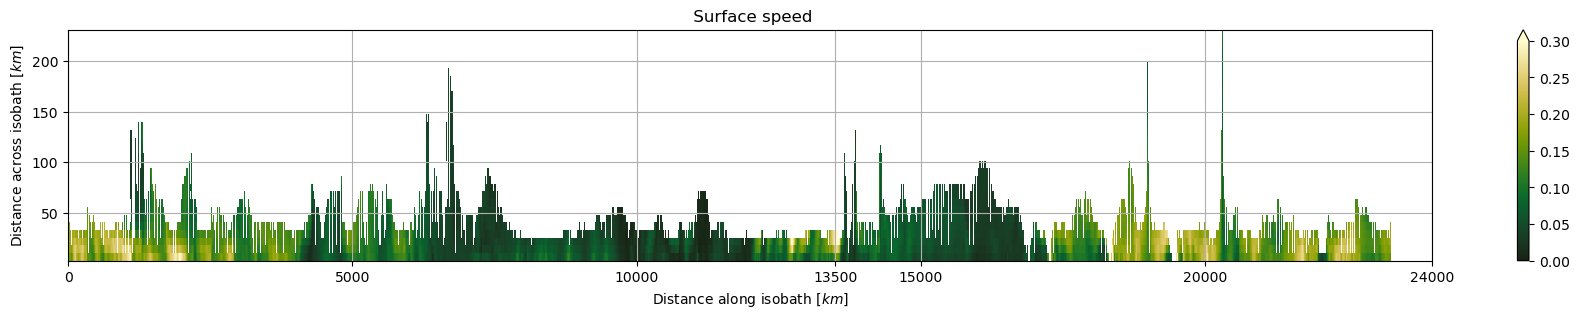

In [53]:

fig, ax1 = plt.subplots(figsize=(22,3))
Speed_01_regridded.plot(vmin=0,vmax=0.3,cmap=cm.cm.speed_r)
ticks_secondary = [0,5000,10000,15000,20000]
plt.xlabel(r'Distance along isobath [$km$]')
plt.ylabel(r'Distance across isobath [$km$]')
ax1.set_xlim(0,24000)
plt.xticks([0,5000,10000,13500,15000,20000,24000])
plt.title(' Surface speed')
plt.grid()

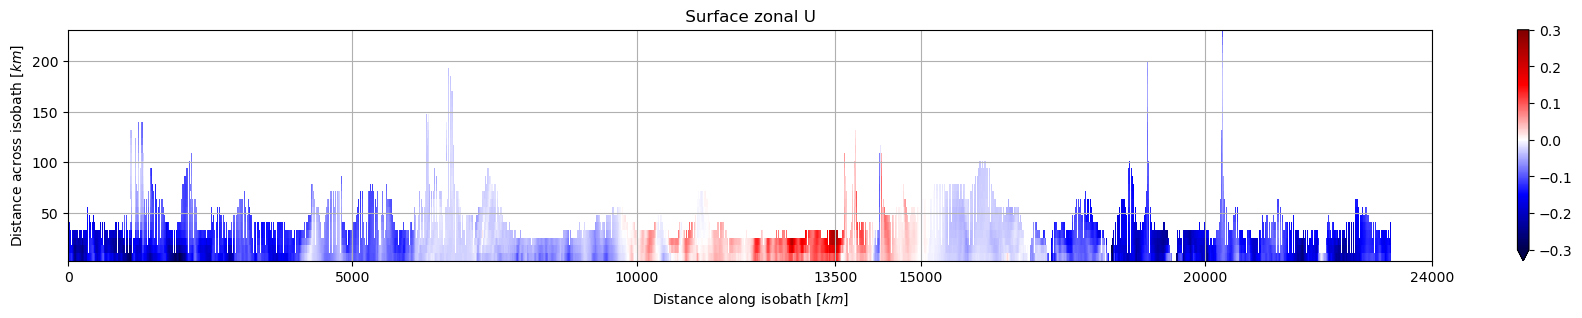

In [55]:
def wrapper(distances,longs,long_inds):
    return longs[ind]

fig, ax1 = plt.subplots(figsize=(22,3))
Us_01_regridded.plot(vmin=-.3,vmax=0.3,cmap='seismic')
ticks_secondary = [0,5000,10000,15000,20000]
plt.xlabel(r'Distance along isobath [$km$]')
plt.ylabel(r'Distance across isobath [$km$]')
ax1.set_xlim(0,24000)
plt.xticks([0,5000,10000,13500,15000,20000,24000])
plt.title(' Surface zonal U ')
plt.grid()

(0.0, 24000.0)

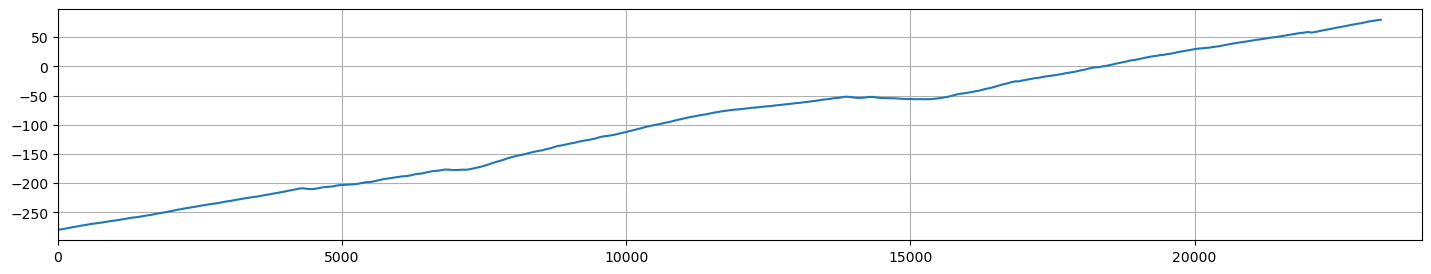

In [52]:
fig, ax1 = plt.subplots(figsize=(17.6,3))
plt.plot(xr_distances_along_isobath_700m_linear,longitudes_700m)
plt.grid()
plt.xlim(0,24000)